In [81]:
import pandas as pd
import pickle
import numpy as np
from typing import Any, List
from dataclasses import dataclass

## Load the features

In [82]:
features_fp = '../../data/features/features_texas_florida.pkl'

@dataclass
class Feature:
    data: pd.DataFrame | np.ndarray
    col: str
    type: str
    models: dict | None
    params: dict | None

    def __str__(self):
        return f"{self.type} ({self.col}) - {self.params}"
    
    __repr__ = __str__


features: List[Feature] = pickle.load(open(features_fp, 'rb'))
features

[amenities (amenities) - {'corr_thresh': 0.05, 'amenities': ['amenity005_lockbox', 'amenity005_pool', 'amenity005_dishwasher', 'amenity005_tv', 'amenity005_keypad', 'amenity005_kitchen', 'amenity005_breakfast']},
 amenities (amenities) - {'corr_thresh': None, 'amenities': ['amenityall_kitchen', 'amenityall_garden', 'amenityall_microwave', 'amenityall_backyard', 'amenityall_iron', 'amenityall_shampoo', 'amenityall_wifi', 'amenityall_pool', 'amenityall_heating', 'amenityall_keypad', 'amenityall_refrigerator', 'amenityall_dog', 'amenityall_cat', 'amenityall_tv', 'amenityall_family', 'amenityall_internet', 'amenityall_patio', 'amenityall_washer', 'amenityall_dryer', 'amenityall_balcony', 'amenityall_stove', 'amenityall_breakfast', 'amenityall_dishwasher', 'amenityall_silverware', 'amenityall_bathtub', 'amenityall_lockbox', 'amenityall_crib', 'amenityall_elevator', 'amenityall_gym', 'amenityall_oven', 'amenityall_waterfront', 'amenityall_toilet']},
 embeddings (comments) - {'vector_size': 5

## Break down the features into combinations we want to test

In [83]:
# get all unique feature types and col combinations
feature_types_col_combos = set([(f.type, f.col) for f in features])
feature_types_col_combos

{('amenities', 'amenities'),
 ('embeddings', 'comments'),
 ('embeddings', 'description'),
 ('pca', 'comments'),
 ('pca', 'comments+amenities'),
 ('pca', 'description'),
 ('pca', 'description+amenities')}

In [85]:
def get_features_by_type_and_col(feature_type: str, col: str="") -> List[Feature]:
    if col == "":
        col = feature_type
    return list(filter(lambda f: f.type == feature_type and f.col == col, features))

@dataclass
class ComboSet:
    name: str
    features: List[List[Feature]]

combos_sets = [
    ComboSet("Amenities and PCA",
             [
        get_features_by_type_and_col("amenities"), 
        get_features_by_type_and_col("pca", "comments"),
        get_features_by_type_and_col("pca", "description"),
    ]),
    # ComboSet("Amenities and embeddings", [
    #     get_features_by_type_and_col("amenities"),
    #     get_features_by_type_and_col("embeddings", "comments"),
    #     get_features_by_type_and_col("embeddings", "description"),
    # ]),
    # ComboSet("PCA over amenities and embeddings", [
    #     get_features_by_type_and_col("pca", "comments+amenities"),
    #     get_features_by_type_and_col("pca", "description+amenities"),
    # ])
]

## Train a classifier on all combinations of features

### Load labels

In [86]:
# Read in the data
GEO = ["texas", "florida"]

if isinstance(GEO, str):
    df = pd.read_csv(f"../../data/processed/{GEO}_auto_processed.csv")
elif isinstance(GEO, list):
    dfs = []
    for geo in GEO:
        df = pd.read_csv(f"../../data/processed/{geo}_auto_processed.csv")
        df["source"] = geo
        dfs.append(df)
    df = pd.concat(dfs)

df.reset_index(drop=True, inplace=True)

labels = df.label
labels

0        good
1        good
2        good
3        good
4        good
        ...  
1541     mbad
1542     mbad
1543     mbad
1544    mgood
1545     mbad
Name: label, Length: 1546, dtype: object

In [87]:
# import KNN Classifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
import itertools
from sklearn.model_selection import train_test_split

def balance_data(data):

    oversample = SMOTE()
    X, y = oversample.fit_resample(data, labels)

    return X, y

def process_combo(combo):
    # Get the features
    features = [f.data for f in combo]

    # check if features is only a list of Nones
    if all([f is None for f in features]):
        return None, None

    # Combine the features while maintaining the column names
    X = pd.concat(features, axis=1)

    # Balance the data
    X, y = balance_data(X)

    return X, y

log = []
def log_it(msg):
    print(msg)
    log.append(msg)

best_model = None
best_combo: List[Feature] | None = None
best_accuracy = 0

i = 0
for combo_set in combos_sets:

    # get cartesian product of features
    for combo in itertools.product(*combo_set.features):

        i += 1
        log_it(f"{i}/1800 - {combo_set.name}: {combo}")

        X, y = process_combo(combo)
        if X is None:
            continue

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train the model
        tuned = KNeighborsClassifier(**{'leaf_size': 10, 'n_neighbors': 3})
        # tuned = ExtraTreesClassifier(**{'max_depth': 10, 'n_estimators': 100})
        tuned.fit(X_train, y_train)

        # Get the accuracy
        accuracy = tuned.score(X_test, y_test)
        # update the best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = tuned
            best_combo = combo
            log_it(f"New Best Accuracy: {accuracy}")
        else:
            log_it(f"Accuracy: {accuracy} (best: {best_accuracy})")


log_it(f"Best Combo: {best_combo}")
log_it(f"Best Accuracy: {best_accuracy}")

1/1800 - Amenities and PCA: (amenities (amenities) - {'corr_thresh': 0.05, 'amenities': ['amenity005_lockbox', 'amenity005_pool', 'amenity005_dishwasher', 'amenity005_tv', 'amenity005_keypad', 'amenity005_kitchen', 'amenity005_breakfast']}, pca (comments) - {'n_components': 3, 'vector_size': 50}, pca (description) - {'n_components': 3, 'vector_size': 50})
New Best Accuracy: 0.8928210313447927
2/1800 - Amenities and PCA: (amenities (amenities) - {'corr_thresh': 0.05, 'amenities': ['amenity005_lockbox', 'amenity005_pool', 'amenity005_dishwasher', 'amenity005_tv', 'amenity005_keypad', 'amenity005_kitchen', 'amenity005_breakfast']}, pca (comments) - {'n_components': 3, 'vector_size': 50}, pca (description) - {'n_components': 5, 'vector_size': 50})
Accuracy: 0.8897876643073812 (best: 0.8928210313447927)
3/1800 - Amenities and PCA: (amenities (amenities) - {'corr_thresh': 0.05, 'amenities': ['amenity005_lockbox', 'amenity005_pool', 'amenity005_dishwasher', 'amenity005_tv', 'amenity005_keypad

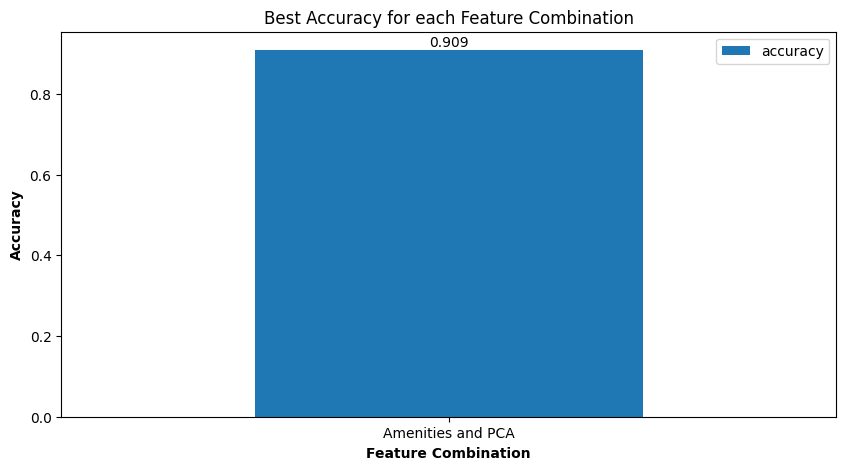

In [88]:
import matplotlib.pyplot as plt

accuracies = []
for line in log:

    if "Best" in line:
        continue

    if "Accuracy" not in line:
        combo_type = line.split("-")[1]
        combo_type = combo_type.split(":")[0].strip()
        accuracies.append({"combo_type": combo_type})
    else:
        accuracies[-1]["accuracy"] = float(line.split(" ")[1])

accuracies = pd.DataFrame(accuracies)

# group by combo type and get the max accuracy
accuracies = accuracies.groupby("combo_type").max().reset_index()

accuracies.plot(kind="bar", x="combo_type", y="accuracy")

# label bar height to 3 decimal places on top of the bar, centered
for i, v in enumerate(accuracies.accuracy):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")

# labels
plt.xticks(rotation=0, ha="center")
plt.xlabel("Feature Combination")
plt.ylabel("Accuracy")
plt.title("Best Accuracy for each Feature Combination")

# make plot wide
plt.gcf().set_size_inches(10, 5)

# bold x and y label
plt.gca().xaxis.label.set_weight("bold")
plt.gca().yaxis.label.set_weight("bold")


plt.show()

## Hyperparameter tuning

In [89]:
# hyperparameter tune the best model
from sklearn.model_selection import GridSearchCV

# Create the parameter grid for extratreesclassifier
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
# }

# create the parameter grid for knn
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'leaf_size': [10, 20, 30, 40, 50]
}

data = [f.data for f in best_combo]
X = pd.concat(data, axis=1)
X, y = balance_data(X)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = tuned, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X, y)

# {'max_depth': 90, 'n_estimators': 500}
grid_search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'leaf_size': 10, 'n_neighbors': 3}

## Evalulate best model with accuracy and confusion matrix

KNeighborsClassifier(leaf_size=10, n_neighbors=3)
amenities (amenities) - {'corr_thresh': 0.05, 'amenities': ['amenity005_lockbox', 'amenity005_pool', 'amenity005_dishwasher', 'amenity005_tv', 'amenity005_keypad', 'amenity005_kitchen', 'amenity005_breakfast']}
pca (comments) - {'n_components': 5, 'vector_size': 200}
pca (description) - {'n_components': 10, 'vector_size': 1000}
Hyperparameter-tuned accuracy: 90.09%


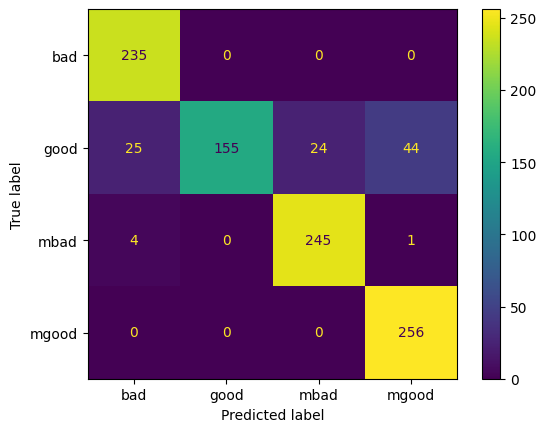

In [90]:
BINARY_LABELS = False

# predict with best params
tuned = KNeighborsClassifier(**grid_search.best_params_)
# tuned = ExtraTreesClassifier(**{'max_depth': 10, 'n_estimators': 100})


data = [f.data for f in best_combo]
X = pd.concat(data, axis=1)
X, y = balance_data(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tuned.fit(X_train, y_train)

y_pred = tuned.predict(X_test)

# plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# print info about model and features
print(tuned)
for f in best_combo:
    print(f)

test = pd.concat([X_test, y_test], axis=1)

if BINARY_LABELS:

    # combine mgood and mbad into "misleading" and good and bad into "not misleading"
    test_adj = test.copy()
    y_pred_adj = y_pred.copy()
    test_adj.label = test_adj.label.replace({"mgood": "misleading", "mbad": "misleading", "good": "not misleading", "bad": "not misleading"})
    y_pred_adj = y_pred_adj.replace({"mgood": "misleading", "mbad": "misleading", "good": "not misleading", "bad": "not misleading"})

    cm = ConfusionMatrixDisplay.from_predictions(test_adj.label, y_pred_adj)

    # calculate the accuracy
    accuracy = accuracy_score(test_adj.label, y_pred_adj)
    print(f"Hyperparameter-tuned accuracy: {accuracy:.2%}")

else:

    cm = ConfusionMatrixDisplay.from_predictions(test.label, y_pred)

    # calculate the accuracy
    accuracy = accuracy_score(test.label, y_pred)
    print(f"Hyperparameter-tuned accuracy: {accuracy:.2%}")

plt.show()

In [91]:
# save the best model

save_fp = "../../models/knn_tuned.pkl"

pickle.dump({
    "model": tuned,
    "combo": best_combo,
}, open(save_fp, "wb"))